In [50]:
%matplotlib inline
import numpy
import math
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import matplotlib.pyplot as plt
import scipy

In [51]:
def generate_dataset(steps, P0, Q):
    x = numpy.zeros((steps + 1,))
    y = numpy.zeros((steps + 1,))
    x[0] = numpy.random.multivariate_normal((0.0,), P0)
    y[0] = numpy.random.binomial(1,numpy.exp(x[0])/(1.0+numpy.exp(x)[0]))
    for k in range(0, steps):
        x[k + 1] = x[k] + numpy.random.multivariate_normal((0.0,), Q)
        y[k + 1] = numpy.random.binomial(1,numpy.exp(x[k+1])/(1.0 + numpy.exp(x[k+1])))

    return (x, y)

In [52]:
from scipy.stats import bernoulli
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v,
    # y_k = Bernoulli(\exp(x_{k})/(1+\exp(x_{k})))= g(x_k),
    # x(0) ~ N(0,P0), v_k ~ N(0,Q)

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
        return particles-particles
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
        lpy = numpy.empty(N)
        g = self.calc_g(particles=particles, t=t)
 

        if (g is None):
            g = numpy.repeat(self.g.reshape((1, -1, 1)), N, 0)
        else:
            g = g.reshape((N, -1, 1))
        yrep = numpy.repeat(numpy.asarray(y).reshape((1, -1, 1)), N, 0)
        diff = yrep - g
        
        lpy = numpy.empty(N)
        for i in xrange(N):
            lpy[i] = bernoulli.pmf(diff[i],particles[i])

        return lpy

In [53]:
T = 40
P0 = 1.0 * numpy.eye(1)
Q = 1.0 * numpy.eye(1)

# Forward particles
N = 100
# Backward trajectories
M = 10

In [54]:
model = StdNonLin(P0, Q)

In [55]:
numpy.random.seed(0)
(x, y) = generate_dataset(T, P0, Q)
print y

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.]


In [56]:
sim = simulator.Simulator(model, u=None, y=y)
sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)

0

In [57]:
(est_filt, w_filt) = sim.get_filtered_estimates()
mean_filt = sim.get_filtered_mean()

In [60]:
est_smooth = sim.get_smoothed_estimates()

mean_smooth = sim.get_smoothed_mean()

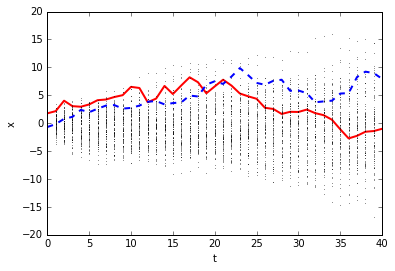

In [61]:
plt.plot(range(T + 1), x, 'r-', linewidth=2.0, label='True')
plt.plot((0,) * N, est_filt[0, :, 0].ravel(), 'k.',
        markersize=0.5, label='Particles')
for t in xrange(1, T + 1):
    plt.plot((t,) * N, est_filt[t, :, 0].ravel(),
             'k.', markersize=0.5)
plt.plot(range(T + 1), mean_filt[:, 0], 'g--',
         linewidth=2.0, label='Filter mean')
plt.plot(range(T + 1), mean_smooth[:, 0], 'b--',
         linewidth=2.0, label='Smoother mean')
plt.xlabel('t')
plt.ylabel('x')

array([ 1.76405235,  2.16420955,  4.03176754,  3.05448966,  2.95127081,
        3.36186931,  4.12290704,  4.24458206,  4.68844529,  5.02211962,
        6.51619869,  6.31104043,  3.75805061,  4.41166921,  6.68142383,
        5.22705815,  6.75983737,  8.22919614,  7.34141039,  5.36061392,
        6.5909046 ,  7.79328445,  6.74473149,  5.32471355,  4.81506137,
        4.37698707,  2.76308922,  2.55034894,  1.65488238,  2.04178488,
        2.01360265,  2.44193452,  1.80761242,  1.44487126,  0.63172498,
       -1.09455763, -2.72475597, -2.26197372, -1.53288316, -1.40390024,
       -1.0015586 ])